In [267]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import random

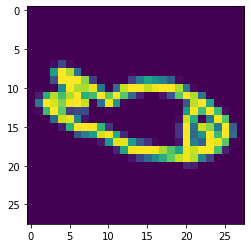

In [18]:
fish_drawings = np.load('data/full_numpy_bitmap_fish.npy').reshape((-1, 28, 28))
plt.imshow(fish_drawings[0], interpolation='nearest')
plt.show()

In [292]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (3, 3), padding=(1, 1)) # 1x28x28 -> 8x14x14
        self.conv2 = nn.Conv2d(8, 8, (3, 3), padding=(1, 1)) # 8x14x14 -> 8x7x7
        self.conv3 = nn.Conv2d(8, 16, (3, 3)) # 8x7x7 -> 16x2x2
        
        self.linear1 = nn.Linear(64, 48)
        self.linear2 = nn.Linear(48, 32)
        self.linear3 = nn.Linear(32, 24)
        
        self.uplinear1 = nn.Linear(24, 32)
        self.uplinear2 = nn.Linear(32, 48)
        self.uplinear3 = nn.Linear(48, 64)
        
        self.deconv1 = nn.Conv2d(16, 8, (3, 3), padding=(2, 2)) # 2x2x16 -> 6x6x8
        self.deconv2 = nn.Conv2d(8, 8, (3, 3), padding=(2, 2)) # 6x6x8 -> 12x12x8
        self.deconv3 = nn.Conv2d(8, 1, (3, 3), padding=(1, 1)) # 12x12x8 -> 28x28x1
        
        
    def forward(self, x):
        x, (pool1_indicies, pool2_indicies, pool3_indicies) = self.encode(x)
        x = self.decode(x, (pool1_indicies, pool2_indicies, pool3_indicies))
        
        return x
    
    def encode(self, x):
        # make sure it's 2d, that there's one channel, and that it's encoded as batch
        x = torch.reshape(x, (-1, 1, 28, 28))
        
        # reduce with conv & pool; 28x28x1 -> 2x2x8
        x = self.conv1(x)
        x, pool1_indicies = nn.MaxPool2d((2, 2), return_indices=True)(x)
        x = nn.LeakyReLU()(x)
        
        x = self.conv2(x)
        x, pool2_indicies = nn.MaxPool2d((2, 2), return_indices=True)(x)
        x = nn.LeakyReLU()(x)
        
        x = self.conv3(x)
        x, pool3_indicies = nn.MaxPool2d((2, 2), return_indices=True)(x)
        x = nn.LeakyReLU()(x)
        
        # reduce with fully connected from 2x2x16 (64) -> 16
        x = torch.reshape(x, (-1, 64))
        
        x = self.linear1(x)
        x = nn.LeakyReLU()(x)
        
        x = self.linear2(x)
        x = nn.LeakyReLU()(x)
        
        x = self.linear3(x)
        x = nn.LeakyReLU()(x)
        
        return x, (pool1_indicies, pool2_indicies, pool3_indicies)
    
    def decode(self, x, pool_indicies):
        # currently trying WITHOUT unpooling; just upsampling
        #(pool1_indicies, pool2_indicies, pool3_indicies) = pool_indicies
        
        #nn.Upsample(scale_factor=2, mode='nearest')
        
        #print(pool1_indicies)
        
        x = self.uplinear1(x)
        x = nn.LeakyReLU()(x)
        
        x = self.uplinear2(x)
        x = nn.LeakyReLU()(x)
        
        x = self.uplinear3(x)
        x = nn.LeakyReLU()(x)
        
        x = torch.reshape(x, (-1, 16, 2, 2))
        
        x = nn.Upsample(scale_factor=2)(x)
        x = self.deconv1(x)
        x = nn.LeakyReLU()(x)
           
        x = nn.Upsample(scale_factor=2)(x)
        x = self.deconv2(x)
        x = nn.LeakyReLU()(x)
        
        x = nn.Upsample(scale_factor=2)(x)
        x = self.deconv3(x)
        x = nn.LeakyReLU()(x)
        
        return x
        
    
ae = AutoEncoder()

In [293]:
def train_auto_encoder(model, data):
    epoch_count = 1
    batch_size = 16
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
    for epoch_index in range(epoch_count):
        batch_count = len(data) // batch_size

        
        for batch_index in range(batch_count):
            batch = data[np.random.randint(0, len(data) - 1, (batch_size,))]
            print('batch', batch.shape)
            x = torch.from_numpy(batch).float()
            y = ae(x).reshape((-1, 28, 28))
            
            optimizer.zero_grad()
            loss = nn.MSELoss()(x, y)
            loss.backward()
            optimizer.step()
            
            clear_output(wait=True)
            print(str(batch_index) + '/' + str(batch_count))
            print('Loss:', loss.item())
    
train_auto_encoder(ae, fish_drawings)

8383/8384
Loss: 2840.552734375


ORIGINAL


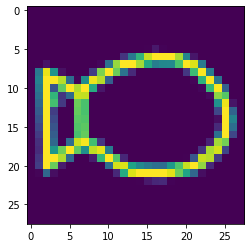

RECONSTRUCTION


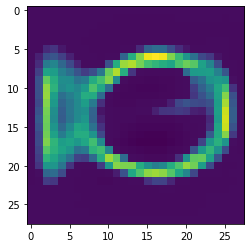

In [312]:
def random_example(model, data):
    original = data[random.randrange(0, len(data))]
    
    x = torch.from_numpy(original).float()
    y = ae(x).reshape((-1, 28, 28))
    
    print('ORIGINAL')
    plt.imshow(x, interpolation='nearest')
    plt.show()
    
    print('RECONSTRUCTION')
    plt.imshow(y.detach().numpy().reshape((28,28)), interpolation='nearest')
    plt.show()
    
random_example(ae, fish_drawings)